# Project 3 : Collaboration and Competition

---

In this notebook, we will use the **Tennis** Unity ML-Agents environment.

## 1. Model & Algorithm used

### 1.1. Algorithm
I've decided to use the DDPG algorithm and I've reused the multi-agent version of the code implemented for project 2 (https://github.com/Neuronys/DRL-ContinuousControl.git). the code for the model ('model.py') and the agent ('multi_agent.py') is highly inspired from:
https://github.com/udacity/deep-reinforcement-learning/blob/55474449a112fa72323f484c4b7a498c8dc84be1/ddpg-bipedal/model.py and 
https://github.com/udacity/deep-reinforcement-learning/blob/55474449a112fa72323f484c4b7a498c8dc84be1/ddpg-bipedal/ddpg_agent.py
, but adding the multi agent capability.

My notebook is solving this project with 2 agents using their own DDPG algorithm, but sharing a common replay buffer to sample individually from it.

### 1.2. Model
Both Actor & Critic are implemented using deep neural networks with 2 hidden layers. I have experimented various architecture:
- fc1 = 256 & fc2 = 128
- fc1 = 256 & fc2 = 256
- fc1 = 512 & fc2 = 256
- fc1 = 512 & fc2 = 384

And it appears that the last one (fc1 = 512 & fc2 = 384) is converging better and faster.
As suggested in the Slack channel and tested already in the previous project, I have tried to add a Batch Normalization layer after the first layer, but it didn't improve the convergence. It was also suggested to use leaky_relu instead of rely for the Critic neural network, but I didn't notice improvement.

### 1.3. Hyper parameters
Convergence mainly came when I've started to tweak the hyper parameters:
- I've doubled the size of the batch
- I've drastically increased TAU 
- I've restored the learning rate of the Actor neural network to its orginal value (as I've changed it for project 2).

The final configuration is:
- BUFFER_SIZE = int(1e6)
- BATCH_SIZE = 128
- GAMMA = 0.99
- TAU = 0.33
- LR_ACTOR = 0.0001
- LR_CRITIC = 0.0001
- WEIGHT_DECAY = 0

The Tennis environment is solved is less than 800 episodes, which seems a good result compared to others results on Slack. 

## 2. Start the Environment

Run the next code cell to install a few packages. This line will take a few minutes to run !

In [1]:
# Watch for changes in any of the imported files
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

from multi_agent import Agent

The environment is already saved in the Workspace and can be accessed at the file path provided below.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 3. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net.
- **Positive Rewards:** +0.1 if an agent hits the ball over the net.
- **Negative Rewards:** -0.01 if an agent lets a ball hit the ground or hits the ball out of bounds.
- **Observation Space:** 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.
- **Action Space:** Two continuous actions are available: 1) movement toward (or away from) the net, and 2) jumping. 

So, the **Goal** of each agent is to keep the ball in play.

The task is episodic, and in order to solve the environment, our agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents).

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 4. Train the 2 agents

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [6]:
# multi-agent DDPG algo
def ddpg_ma(n_episodes=2000):
    scores = []
    scores_deque = deque(maxlen=100)
    
    for e in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations            # get the current state

        # Initialize the score for each agent
        score = np.zeros(num_agents)
        
        # Keep track of the current timestep
        t = 0
        while True:
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
            # Print the current mean score across all agents
            print(f'\rEpisode #{e}\tTimestep #{t}'
                  f'\tScore = {np.mean(score):.5f}', end="")
            t += 1

            if np.any(done):
                break 

        # add up the rewards that each agent received
        scores_sum = []
        for i in range(num_agents):
            scores_sum.append(np.sum(score[i]))
        
        # For this episode, take the max score over the two agent
        max_score = np.max(scores_sum)

        # Save the most recent score
        scores.append(max_score)
        scores_deque.append(max_score)
        
        # Record the mean score over the last 100 scores
        mean_score = np.mean(scores_deque)

        # Every 20 episodes, print the mean score over the last 100 episodes
        if e % 20 == 0:
            print(f'\rEpisode #{e}'
                  f'\tAverage score (over the last 100 episodes) = {mean_score:.5f}')
            
        # Goal: Reach 0.5 (or more) over 100 consecutive episodes
        if mean_score >= 0.5:
            print(f'\nTennis environment solved in {e:d} episodes!'
                  f'\tAverage score (over the last 100 episodes) = {mean_score:.5f}')
            
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            break
            
    return scores

In [7]:
# Instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=22)
# Train the DDPG agent
scores = ddpg_ma(n_episodes=1000)


Episode #20	Average score (over the last 100 episodes) = 0.00000
Episode #40	Average score (over the last 100 episodes) = 0.00000
Episode #60	Average score (over the last 100 episodes) = 0.00000
Episode #80	Average score (over the last 100 episodes) = 0.00125
Episode #100	Average score (over the last 100 episodes) = 0.00100
Episode #120	Average score (over the last 100 episodes) = 0.00100
Episode #140	Average score (over the last 100 episodes) = 0.00100
Episode #160	Average score (over the last 100 episodes) = 0.00200
Episode #180	Average score (over the last 100 episodes) = 0.00100
Episode #200	Average score (over the last 100 episodes) = 0.00200
Episode #220	Average score (over the last 100 episodes) = 0.00200
Episode #240	Average score (over the last 100 episodes) = 0.00200
Episode #260	Average score (over the last 100 episodes) = 0.00490
Episode #280	Average score (over the last 100 episodes) = 0.01150
Episode #300	Average score (over the last 100 episodes) = 0.01890
Episode #320	A

## 5. Plot the result

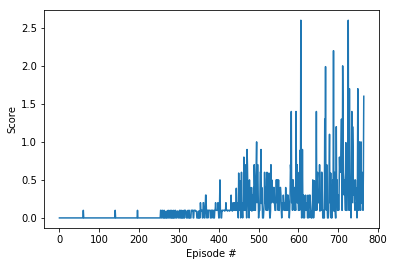

In [8]:
# Plot the result
plot_scores(scores)

In [9]:
env.close()

## 6. Future work (already suggested in project 2)
I've focussed on DDPG but there are DDPG improvements to try, such as D3PG and D4PG, A3C and PPO:
- In the Slack channel, some students have reported great results using PPO instead of DDPG.
- In this paper written by Barth-Maron et al 2018 D4PG has achieved state of the art results on continuous control problems.

However there is still room for improvement on the DDPG algorithm:
- use priority in the Replay Buffer
- adjust the Ornstein-Uhlenbeck noise level